In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_no_constraint import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
# problem_spec['vector_size'] = 10
problem_spec['vector_size'] = 10
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

# problem_data['rho'] = 0.01

problem_spec['sc_eps'] = 1

# PG-EXTRA hyperparameters
problem_data['alpha'] = 2.5
problem_data['itr_num'] = 10000

{'n_node': 6, 'vector_size': 10}


In [3]:
x = cp.Variable(problem_spec['vector_size'])

Q = problem_data['Q']
b = problem_data['b']

for j in range(problem_spec['n_node']):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.min(s)])

[0.010018240051248373, 0.010000009426217265]
[0.010020333473900297, 0.01000000151481438]
[0.010016787631051067, 0.01000001012816897]
[0.010018687326139345, 0.010000000919375683]
[0.010015290187466348, 0.010000001759092096]
[0.010017347156888498, 0.010000009988645107]


In [4]:
# nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
# plt.savefig("plots/graph_n6.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-726.1590205278219, np.linalg.norm(x_opt_star)=380.78241850349747


In [6]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-726.1590205278219, np.linalg.norm(x_opt_star)=155.45377139274808


In [7]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
eps = problem_spec['sc_eps']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    # prox_operators += [lambda z, alpha: np.squeeze( np.dot( np.linalg.inv(Q[jj] + 1/alpha * np.eye(vector_size)) , ( z - 1/alpha * b[jj] ).T ) ) ]
    prox_operators += [lambda z, alpha: prox_fj_quad_no_constraint(z, alpha, problem_spec, problem_data, jj) ]
    # prox_operators += [lambda z, alpha:  cvx_prox_fj_quad_no_constraint(z, alpha, problem_spec, problem_data, jj, eps=1e-4)]
    fi_operators += [lambda x_kj : (1/2 * x_kj @ Q[jj] @ x_kj.T + b[jj] @ x_kj)[0] ]

    z = np.random.randn(vector_size)
    x1 = prox_fj_quad_no_constraint(z, 1/5, problem_spec, problem_data, jj)
    x2 = cvx_prox_fj_quad_no_constraint(z, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

In [8]:
# params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
# dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
#                                                                                 network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                                 fi_operators=fi_operators,
#                                                                                 params=params, printing=True, freq=200)

In [9]:
params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9877761938785525, err_opt_reldiff[-1]=0.9926277424374973
ii=200, f_reldiff[-1]=0.47378621350626215, err_opt_reldiff[-1]=0.5461287214071036
ii=400, f_reldiff[-1]=0.45298662458057387, err_opt_reldiff[-1]=0.4926938872445658
ii=600, f_reldiff[-1]=0.45215069224960497, err_opt_reldiff[-1]=0.4847418526486671
ii=800, f_reldiff[-1]=0.45211709607661643, err_opt_reldiff[-1]=0.48327490345775265
ii=1000, f_reldiff[-1]=0.4521157458370925, err_opt_reldiff[-1]=0.48298671922512093
ii=1200, f_reldiff[-1]=0.4521156915703001, err_opt_reldiff[-1]=0.48292932192697013
ii=1400, f_reldiff[-1]=0.4521156893892793, err_opt_reldiff[-1]=0.48291785809987336
ii=1600, f_reldiff[-1]=0.45211568930162216, err_opt_reldiff[-1]=0.482915567182423
ii=1800, f_reldiff[-1]=0.4521156892980991, err_opt_reldiff[-1]=0.4829151093212636
ii=2000, f_reldiff[-1]=0.4521156892979575, err_opt_reldiff[-1]=0.4829150178124299
ii=2200, f_reldiff[-1]=0.45211568929795176, err_opt_reldiff[-1]=0.482914999523476
ii=2400, f_reld

In [10]:
# R = 10
# admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
#                                                                                 network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                                 fi_operators=fi_operators,
#                                                                                 params={"R":R}, printing=True, freq=200)

In [11]:
R = 2
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9877761938785525, err_opt_reldiff[-1]=0.9926277424374973
ii=200, f_reldiff[-1]=0.46976305015206193, err_opt_reldiff[-1]=0.5385091909214765
ii=400, f_reldiff[-1]=0.4526938138406181, err_opt_reldiff[-1]=0.4907602429606619
ii=600, f_reldiff[-1]=0.4521346286739542, err_opt_reldiff[-1]=0.4842516842562634
ii=800, f_reldiff[-1]=0.4521163097561854, err_opt_reldiff[-1]=0.4831535387973362
ii=1000, f_reldiff[-1]=0.4521157096244267, err_opt_reldiff[-1]=0.4829579463002173
ii=1200, f_reldiff[-1]=0.4521156899638597, err_opt_reldiff[-1]=0.482922741206725
ii=1400, f_reldiff[-1]=0.45211568931976737, err_opt_reldiff[-1]=0.4829163923859469
ii=1600, f_reldiff[-1]=0.45211568929866625, err_opt_reldiff[-1]=0.4829152470633325
ii=1800, f_reldiff[-1]=0.45211568929797513, err_opt_reldiff[-1]=0.48291504043750194
ii=2000, f_reldiff[-1]=0.45211568929795226, err_opt_reldiff[-1]=0.4829150031605288
ii=2200, f_reldiff[-1]=0.45211568929795165, err_opt_reldiff[-1]=0.48291499643554464
ii=2400, f_reldi

In [12]:
# R = 1
# admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
#                                                                                 network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                                 fi_operators=fi_operators,
#                                                                                 params={"R":R}, printing=True, freq=200)

In [13]:
# params={"R":18, "Inductance":10, "h":1.1054814693822324}
# ciradmm_err_opt_star, ciradmm_err_opt_reldiff, ciradmm_const_vio, ciradmm_f_reldiff = co.dadmm("cir_dadmm", problem_spec, problem_data, 
#                                                                                 network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                                 fi_operators=fi_operators,
#                                                                                 params=params, printing=True, freq=200)

In [14]:
# apply P-EXTRA 
# problem_data['alpha'] = 0.5
# pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint( problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

# p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=False, freq=200, params=None)

In [15]:
# apply P-EXTRA 
problem_data['alpha'] = 1
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9742234248342336, err_opt_reldiff[-1]=0.9900982253217001
ii=200, f_reldiff[-1]=0.018196495910063917, err_opt_reldiff[-1]=0.13489446355935109
ii=400, f_reldiff[-1]=0.00033778122982673956, err_opt_reldiff[-1]=0.018378801268003772
ii=600, f_reldiff[-1]=6.270370440846026e-06, err_opt_reldiff[-1]=0.0025040373287154517
ii=800, f_reldiff[-1]=1.164180102574201e-07, err_opt_reldiff[-1]=0.00034116539921923443
ii=1000, f_reldiff[-1]=2.16395350144972e-09, err_opt_reldiff[-1]=4.6482525398812e-05
ii=1200, f_reldiff[-1]=4.056197035582877e-11, err_opt_reldiff[-1]=6.333079247202318e-06
ii=1400, f_reldiff[-1]=8.062796133011616e-13, err_opt_reldiff[-1]=8.628589979865026e-07
ii=1600, f_reldiff[-1]=2.191828074993449e-14, err_opt_reldiff[-1]=1.1755955193585469e-07
ii=1800, f_reldiff[-1]=1.2524731857105424e-15, err_opt_reldiff[-1]=1.6014556629220174e-08
ii=2000, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=2.1790406023274436e-09
ii=2200, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=2.93676647380167

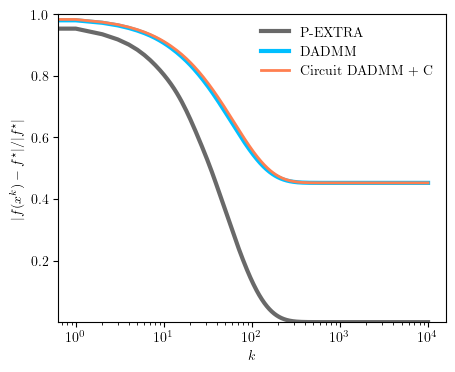

In [16]:
fname = "n6_circuit_dadmm_c"



plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'gold'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
# plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=3)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=3)
# plt.plot(ciradmm_f_reldiff, label='Circuit DADMM',  color=green, linewidth=2)
plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-10, 1e0)
plt.legend()
# plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)